In [1]:
import pandas as pd

DATA_PATH = '../data/'
DATA_PROCESSED_PATH = DATA_PATH + 'processed/'

train = pd.read_csv(DATA_PROCESSED_PATH + 'train10000_0.csv')
val = pd.read_csv(DATA_PROCESSED_PATH + 'val2500_0.csv')

Tokenize

In [2]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

train["tokens"] = train["preprocessed_text"].apply(tokenizer.tokenize)

In [4]:
train.head()

,id,published-at,title,article_text,hyperpartisan,bias,url,labeled-by,preprocessed_text,tokens
0,1049192,2003-05-12,"Time Inc.'s Huey thinks outside the box, makes...","Time Inc.'s Huey thinks outside the box, makes...",False,least,https://poynter.org/news/time-incs-huey-thinks...,publisher,time inc huey think outside box make enemy new...,"[time, inc, huey, think, outside, box, make, e..."
1,923492,NaN,Texas group to open southern NM abortion clinic,Texas group to open southern NM abortion clini...,False,least,https://abqjournal.com/456723/texas-group-to-o...,publisher,texas group open southern nm abortion clinic l...,"[texas, group, open, southern, nm, abortion, c..."
2,1277816,NaN,Texas woman pleads guilty to sex trafficking 9...,Texas woman pleads guilty to sex trafficking 9...,False,least,https://abqjournal.com/1044515/texas-woman-ple...,publisher,texas woman plead guilty sex traffic year old ...,"[texas, woman, plead, guilty, sex, traffic, ye..."
3,777348,2018-01-11,"17 dead in California mudslides, more than a d...","17 dead in California mudslides, more than a d...",False,least,https://apnews.com/amp/67ec5e87bbb74130b7ddedc...,publisher,dead california mudslide dozen miss montecito ...,"[dead, california, mudslide, dozen, miss, mont..."
4,89424,NaN,County needs comprehensive effort to generate ...,County needs comprehensive effort to generate ...,False,least,https://abqjournal.com/309627/county-needs-com...,publisher,county need comprehensive effort generate need...,"[county, need, comprehensive, effort, generate..."


In [6]:
all_words = [word for tokens in train["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in train["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

3959297 words total, with a vocabulary size of 104546
Max sentence length is 9329


In [16]:
sentence_lengths.index(max(sentence_lengths))

9998

In [30]:
train[train['preprocessed_text'].str.len() > 50000]

,id,published-at,title,article_text,hyperpartisan,bias,url,labeled-by,preprocessed_text,tokens
4200,905795,2018-07-16,The Rise and Fall of the Socialist Party of Am...,The Rise and Fall of the Socialist Party of Am...,True,left,https://jacobinmag.com/2017/02/rise-and-fall-s...,publisher,rise fall socialist party america middle berni...,"[rise, fall, socialist, party, america, middle..."


In [19]:
sentence_lengths[9998]

9329

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = train["preprocessed_text"].tolist()
list_labels = train["hyperpartisan"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [4]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [7]:
import sys
sys.path.append('../src/models')

%load_ext autoreload
%autoreload 1

import plot
%aimport plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ValueError: 'c' argument has 9999 elements, which is not acceptable for use with 'x' with size 10, 'y' with size 10.

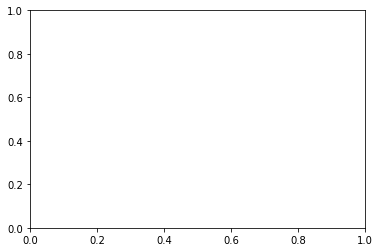

In [18]:
plot.plot_LSA(train)

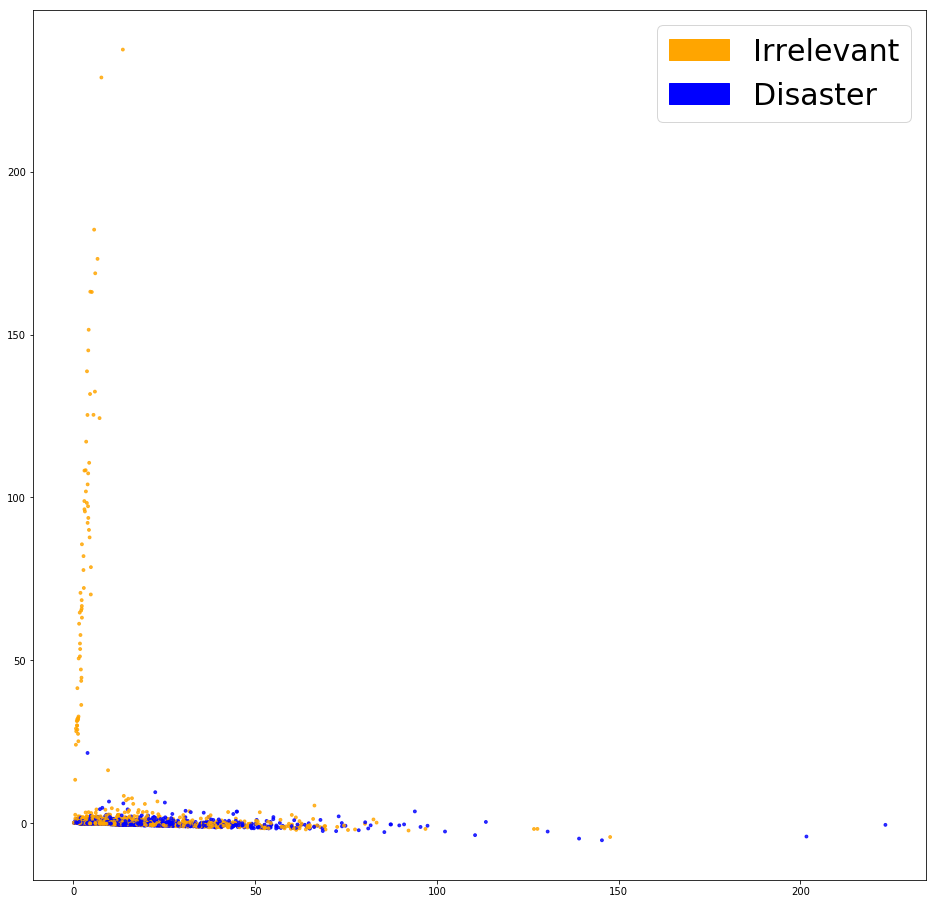

In [25]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = train["preprocessed_text"].tolist()
list_labels = train["hyperpartisan"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

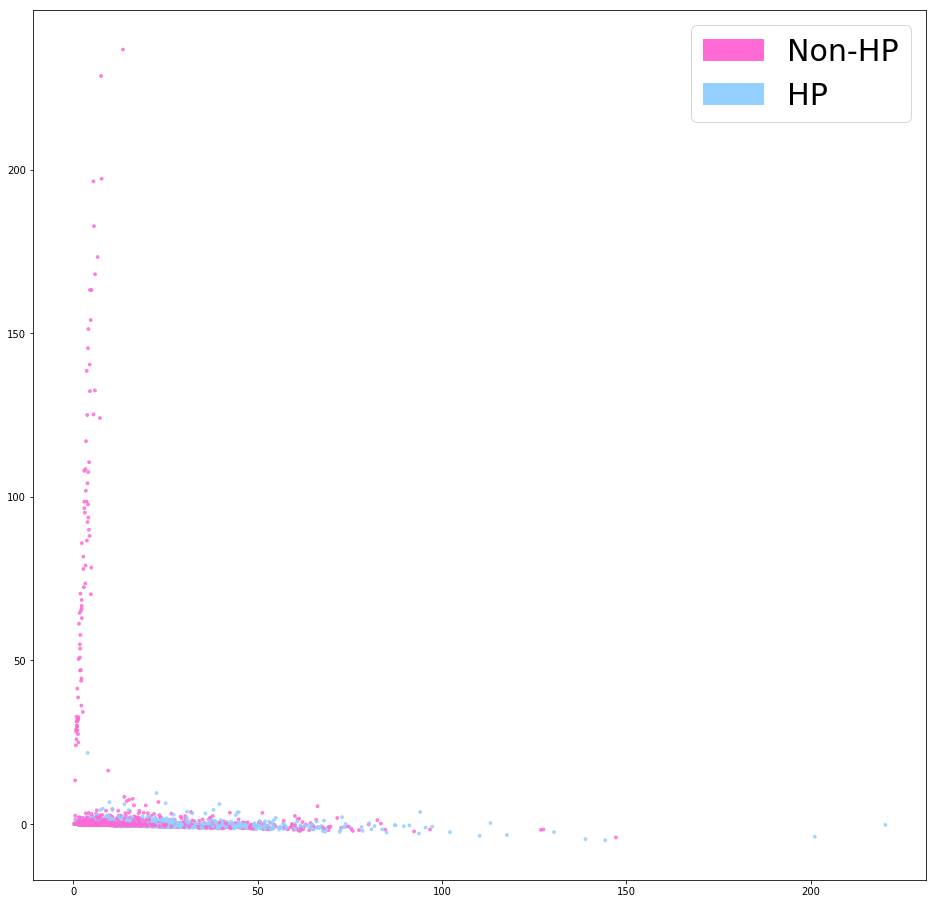

In [58]:
fig = plt.figure(figsize=(16, 16))          
lsa_scores = plot.plot_LSA(train)
plt.show()

In [63]:
lsa_scores

array([[ 2.55968332, -0.06119196],
       [ 2.28429054,  1.06270351],
       [ 2.67887481, -0.08382555],
       ...,
       [ 2.6295049 , -0.05832373],
       [11.93393718, -0.29963695],
       [ 7.83472296,  0.46273185]])

AttributeError: module 'numpy' has no attribute 'arrange'

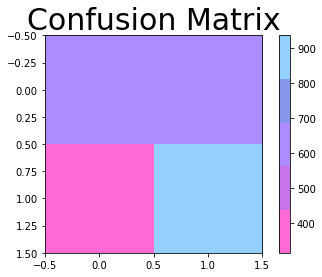

In [67]:
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(train['preprocessed_text'])
y_train = train['hyperpartisan']
clf.fit(X_train_counts, y_train)
X_test = val['preprocessed_text']
X_test_counts = count_vectorizer.transform(X_test)
y_predicted_counts = clf.predict(X_test_counts)

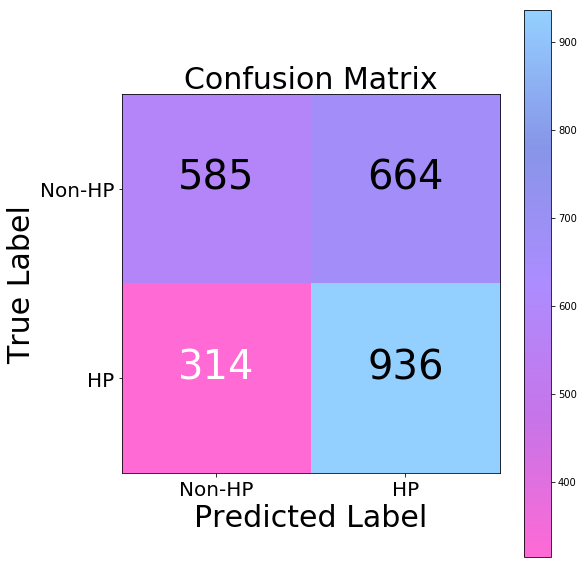

In [72]:
fig = plt.figure(figsize=(8, 8))
plot.plot_confusion_matrix(val['hyperpartisan'], y_predicted_counts)
plt.show()

In [73]:
train.head()

,id,published-at,title,article_text,hyperpartisan,bias,url,labeled-by,preprocessed_text,tokens
0,1049192,2003-05-12,"Time Inc.'s Huey thinks outside the box, makes...","Time Inc.'s Huey thinks outside the box, makes...",False,least,https://poynter.org/news/time-incs-huey-thinks...,publisher,time inc huey think outside box make enemy new...,"[time, inc, huey, think, outside, box, make, e..."
1,923492,NaN,Texas group to open southern NM abortion clinic,Texas group to open southern NM abortion clini...,False,least,https://abqjournal.com/456723/texas-group-to-o...,publisher,texas group open southern nm abortion clinic l...,"[texas, group, open, southern, nm, abortion, c..."
2,1277816,NaN,Texas woman pleads guilty to sex trafficking 9...,Texas woman pleads guilty to sex trafficking 9...,False,least,https://abqjournal.com/1044515/texas-woman-ple...,publisher,texas woman plead guilty sex traffic year old ...,"[texas, woman, plead, guilty, sex, traffic, ye..."
3,777348,2018-01-11,"17 dead in California mudslides, more than a d...","17 dead in California mudslides, more than a d...",False,least,https://apnews.com/amp/67ec5e87bbb74130b7ddedc...,publisher,dead california mudslide dozen miss montecito ...,"[dead, california, mudslide, dozen, miss, mont..."
4,89424,NaN,County needs comprehensive effort to generate ...,County needs comprehensive effort to generate ...,False,least,https://abqjournal.com/309627/county-needs-com...,publisher,county need comprehensive effort generate need...,"[county, need, comprehensive, effort, generate..."
